### Problem Set 3

who is the central player in this
technology area ? Who is the leader ? Who is an irrelevant actor ?

WARNING!

Some function run only until 3.6 version 

In [1]:
import networkx as nx
import operator
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import randint

#import community 
from community import community_louvain

from networkx.algorithms.community import k_clique_communities
from operator import itemgetter

### Data and SQL

In this assignment, we used the data provided on Moodle. However, we did try ourselves getting the data from the Google Patents Public Data (https://console.cloud.google.com/bigquery?p=patents-public-data&d=patents&page=dataset). The results we obtained were, however, different from the edgelist that was provided, in the sense that we had fewer nodes an fewer edges. We wonder if this is the result of us being in only the free tier. 

We proceeded with our BigQuery practice as follow:

- Access to Google BigQuery's API

In [2]:
# DON'T RUN
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/hienle/DSIP-As3-25e0a13c65b2.json"

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(
    credentials=credentials,
    project=your_project_id,
)
bqstorageclient = bigquery_storage_v1beta1.BigQueryStorageClient(
    credentials=credentials
)

- Query all patents from 2016 in the class required ("G06Q30/06")

In [3]:
# DON'T RUN THIS EITHER
query_string = f"""
SELECT ANY_VALUE(a.name) AS assignee_name, ANY_VALUE(pubs.publication_number) as pub_number,
ANY_VALUE(SUBSTR(cpcs.code, 0, 9)) AS cpc_code,
ANY_VALUE(pubs.filing_date) AS filing_date, CAST(FLOOR(ANY_VALUE(filing_date) / 10000) AS INT64) AS filing_year,
ANY_VALUE(pubs.country_code) AS country_code
FROM `patents-public-data.patents.publications` AS pubs, UNNEST(assignee_harmonized) as a,
UNNEST(pubs.cpc) as cpcs
WHERE cpcs.first = TRUE AND REGEXP_CONTAINS(cpcs.code, "G06Q30/06") AND 
filing_date > 20160101
GROUP BY application_number
"""

dataframe = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
print(f"We have in total {dataframe.assignee_name.unique().shape[0]} unique patent assignees")
dataframe.head()

We have in total 4357 unique patent assignees


,assignee_name,pub_number,cpc_code,filing_date,filing_year,country_code
0,LIM SOON SEOP,KR-20200021490-A,G06Q30/06,20200210,2020,KR
1,LIM SOON SEOP,KR-20200021488-A,G06Q30/06,20200210,2020,KR
2,ELECTRONIC COMMODITIES EXCHANGE L P,AU-2020200803-A1,G06Q30/06,20200204,2020,AU
3,LIM SOON SEOP,KR-20200021491-A,G06Q30/06,20200210,2020,KR
4,STRIPE INC,AU-2020201049-A1,G06Q30/06,20200213,2020,AU


- Query cited patents (in class "G06Q30/06") and the ones that cite them (can be in any class, I assume) as well as other information. Both of the source (citing patent) and target (cited patent) should be from 2016 to 2020. The following query does these steps:
    - Create a subquery for references, which are the targets (or cited patents) in the required class and are from 2016 to 2020. This query is more or less like the one above.
    - Create another subquery for the sources (citing patents) where we don't filter for the class any more but still keep the filter for the dates. In this subtable we also get the citations' columns, which contain the publication numbers of each citation that a patent includes. 
    - Join these two subtables by the named ```cited_publication_number``` which will create the link between a citing patent and a cited patent.

In [4]:
# AND DON'T RUN THIS
query_string2 = """
SELECT cited_assignee, refs.cited_publication_number, citing_publication_number, citing_assignee, cited_cpc_code, 
citing_cpc_code, filing_year FROM
(SELECT a.name AS cited_assignee, pubs.publication_number as 
cited_publication_number,
SUBSTR(cpcs.code, 0, 9) AS cited_cpc_code, pubs.filing_date AS filing_date,
CAST(FLOOR(filing_date / 10000) AS INT64) AS filing_year
FROM `patents-public-data.patents.publications` AS pubs, UNNEST(assignee_harmonized) as a,
UNNEST(pubs.cpc) as cpcs
WHERE cpcs.first = TRUE AND REGEXP_CONTAINS(cpcs.code, "G06Q30/06") AND 
filing_date > 20160101
--GROUP BY application_number
) as refs
JOIN (
  SELECT pubs.publication_number AS citing_publication_number, cite.publication_number AS cited_publication_number, 
  citing_assignee_s.name AS citing_assignee, SUBSTR(cpcs.code, 0, 9) AS citing_cpc_code, 
  pubs.filing_date AS citing_filing_date
  FROM `patents-public-data.patents.publications` AS pubs, UNNEST(citation) AS cite, 
  UNNEST(assignee_harmonized) AS citing_assignee_s, UNNEST(cpc) AS cpcs
  WHERE cpcs.first = TRUE AND pubs.filing_date > 20160101
) AS pubs
ON refs.cited_publication_number = pubs.cited_publication_number
GROUP BY citing_publication_number, refs.cited_publication_number, pubs.cited_publication_number, citing_assignee, 
cited_assignee, citing_cpc_code, cited_cpc_code, filing_year
"""


dataframe2 = (
    bqclient.query(query_string2)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
dataframe2.head()

,cited_assignee,cited_publication_number,citing_publication_number,citing_assignee,cited_cpc_code,citing_cpc_code,filing_year
0,BECKHAM BRITTANY FLETCHER,US-2017011452-A1,US-2018218433-A1,FOGEL DAVID,G06Q30/06,G06Q30/06,2016
1,BANK OF AMERICA,US-2018150899-A1,US-2018375660-A1,DELL PRODUCTS LP,G06Q30/06,H04L9/322,2016
2,SQUARE INC,US-9934530-B1,US-10467562-B1,COUPANG CORP,G06Q30/06,G06Q10/06,2016
3,WIECHERS RALPH,US-2017132691-A1,US-10497192-B2,CARRIER CORP,G06Q30/06,G07C9/27,2016
4,KIMREE HI-TECH INC,US-2016260156-A1,US-10159282-B2,JUUL LABS INC,G06Q30/06,A24F47/00,2016


- Now I'm gonna try to make and edgelist by first giving each assignee a unique number, and then test a network on it.

In [5]:
# DON'T RUN DON'T RUN ;)
all_assignees = list(set(list(dataframe2.cited_assignee) + list(dataframe2.citing_assignee)))

d = {name: i for i,name in enumerate(all_assignees)}
df = dataframe2.applymap(lambda s: d.get(s) if s in d else s)[["citing_assignee","cited_assignee"]]

test = nx.from_pandas_edgelist(df, "citing_assignee", "cited_assignee")
print(nx.info(test))

Name: 
Type: Graph
Number of nodes: 2197
Number of edges: 2629
Average degree:   2.3933


##### Despite the logic of the query seeming correct, we shall resort to using the TA's provided file ...

## ANALYSIS


In [11]:
G = nx.read_edgelist('network_prof.txt')
       
# function that generate connected components as subgraphs:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

# check number of components of the network:

graph_max = max(connected_component_subgraphs(G)) # subcomponent with max number of nodes
graph_min = min(connected_component_subgraphs(G)) # subcomponent with min number of nodes

print("Information about the network: \n" + nx.info(G))
print("\nInformation about the max subgraph: \n" + nx.info(graph_max))
print("\nInformation about the min subgraph: \n" + nx.info(graph_min))

if G.number_of_nodes() == graph_max.number_of_nodes():
    # the number of nodes of the network is equal to the max subgraph. so there is only one subgraph.
    # we could have done the same with the min
    print("\nWe only have one directed component")

Information about the network: 
Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910

Information about the max subgraph: 
Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910

Information about the min subgraph: 
Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910

We only have one directed component


In [12]:
# some important variables about the network

nodes = list(G.nodes)
num_nodes = G.number_of_nodes()

#position = nx.spring_layout(G) # position nodes using Fruchterman-Reingold force-directed algorithm.
#with open('position.p', 'wb') as fp:
#    pickle.dump(position, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [13]:
with open('position.p', 'rb') as fp:
    position = pickle.load(fp)

In [14]:
#position1=position
#position2 = nx.spring_layout(G)
#position3 = nx.spring_layout(G)
#position4 = nx.spring_layout(G)

In [15]:
# plot function
def plot_network(G, position, nodes, Z, color_special, first_figure, last_figure, label):
    # G is the graph
    # position is calculated using Fruchterman-Reingold force-directed algorithm.
    # nodes: all nodes
    # Z: subset of nodes to highlight
    # color_special = color of these highlighted nodes
    # first_figure: start a new figure?
    # last_figure: last figure? False if there will be other to put togheter 
    
    if first_figure==True: plt.figure(figsize=(10,10)) #create a new figure
        
    if first_figure == True: # not re-draw nodes/edges if it is not the new figure
        nx.draw_networkx_nodes(G, position, nodes, node_size = 7, node_color = "#fffd37" , alpha = 0.7)
        nx.draw_networkx_edges(G, position, alpha = 0.5)
        
    # special nodes
    if len(Z)>0: # non empty 
        nx.draw_networkx_nodes(G, position, Z, node_size = 17, node_color = color_special)
        #if first_figure==True and last_figure==True:
         #   nx.draw_networkx_labels(G, position, label, font_color= 'b', font_weight='bold', alpha=1)
    
    plt.axis('off')
    
    if last_figure==True: plt.show()
    

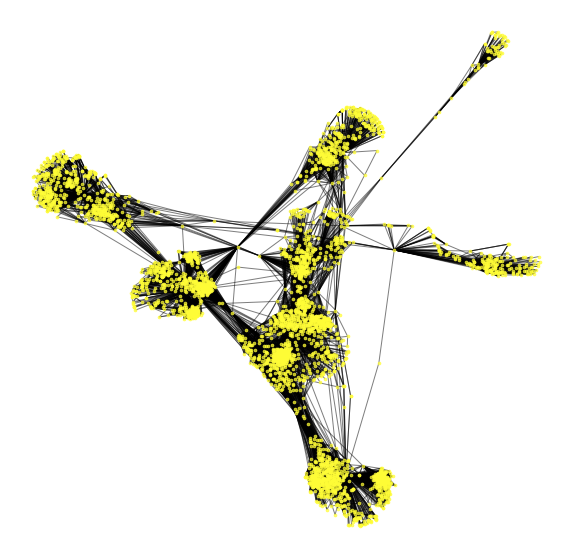

In [16]:
# plot of the network:
plot_network(G, position, nodes, [], 'r', True, True, [])

## Significant Nodes
At this point we have to analyise our network. To understand the leader and irrelevant actors, we measure the vertex importance. We will analize

- Node degree
- Betweenness
- Eigenvector centrality

**Node Degree**: The node degree is the number of edges adjacent to the node

In [17]:
nodes_degree = G.degree
print(f" For example, node number '{list(nodes_degree)[0][0]}' degree is equal to {list(nodes_degree)[0][1]}.")

 For example, node number '0' degree is equal to 347.


In our dataset, each node is a person. Then the degree of that person is the number of people he/she is talking to. Let us see who are the people with more contacts:

In [18]:
# function which calculate centrality of a graph. return nodes in order of centrality
def calculate_centrality(G, nodes):
    degrees = [val for (node, val) in G.degree()] #only the values
    nodes = [node for (node, val) in G.degree()] #only the node

    cen = [x for _,x in sorted(zip(degrees,nodes), reverse=True)]
    return cen

centrality = calculate_centrality(G, nodes)
centrality_10 = centrality[:10]

degree_most_connected = G.degree(centrality)

#degree_most_connected = degree_most_connected[0:10] # first ten nodes

labels= [None] * num_nodes

print("Nodes with highest DEGREE:")
for i in range(10):
    labels[int(np.array(degree_most_connected)[i,0])]=str(i+1)
    print(f"Position #{i+1}: node {list(degree_most_connected)[i][0]} with degree {list(degree_most_connected)[i][1]}")

Nodes with highest DEGREE:
Position #1: node 107 with degree 1045
Position #2: node 1684 with degree 792
Position #3: node 1912 with degree 755
Position #4: node 3437 with degree 547
Position #5: node 0 with degree 347
Position #6: node 2543 with degree 294
Position #7: node 2347 with degree 291
Position #8: node 1888 with degree 254
Position #9: node 1800 with degree 245
Position #10: node 1663 with degree 235


Highlight these nodes in the network:

Highlight nodes with the highest centrality:


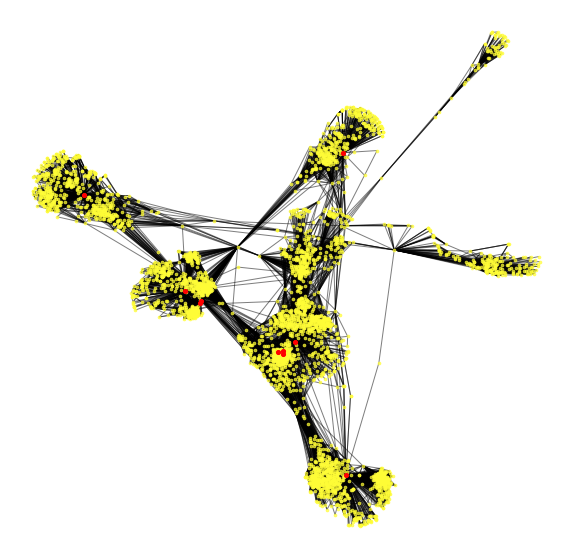

In [19]:
#PRINT

labels = ['' if v is None else v for v in labels]
dic_label = { nodes[labels.index(i)] : str(i) for i in labels }

print("Highlight nodes with the highest centrality:")
plot_network( G, position, nodes, centrality_10, 'r', True, True, dic_label)


**Betweenness**: measures how frequently a mode is in the shortest path between any two nodes

In [20]:
# warning!! the next command is realy slow

#betweenness = nx.betweenness_centrality(G) # compute the shortest-path betweenness centrality for nodes. return a dictionary
#with open('betweenness.p', 'wb') as fp:
#    pickle.dump(betweenness, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('betweenness.p', 'rb') as fp:
    betweenness = pickle.load(fp)

We find the 10 people with highest betweenness. Betweenness centrality measures how important a node is to the shortest paths through the network. Hence, when we talk about links, it is important to find nodes which apprears more often.

In [22]:
high_btw = sorted(betweenness.items(), key=itemgetter(1), reverse=True) #sort
high_btw_10 = high_btw[0:10] # first ten nodes

labels= [None] * num_nodes

print("Nodes with highest BETWEENNESS CENTRALITY:")
for i in range(10):
    labels[int(np.array(high_btw_10)[i,0])]=str(i+1)
    print(f"Position #{i+1}: node; {high_btw_10[i][0]}, betw_cen: {high_btw_10[i][1]}")

Nodes with highest BETWEENNESS CENTRALITY:
Position #1: node; 107, betw_cen: 0.4805180785560152
Position #2: node; 1684, betw_cen: 0.3377974497301992
Position #3: node; 3437, betw_cen: 0.23611535735892905
Position #4: node; 1912, betw_cen: 0.2292953395868782
Position #5: node; 1085, betw_cen: 0.14901509211665306
Position #6: node; 0, betw_cen: 0.14630592147442917
Position #7: node; 698, betw_cen: 0.11533045020560802
Position #8: node; 567, betw_cen: 0.09631033121856215
Position #9: node; 58, betw_cen: 0.08436020590796486
Position #10: node; 428, betw_cen: 0.06430906239323866


Highlight nodes with the highest betweenness centrality:


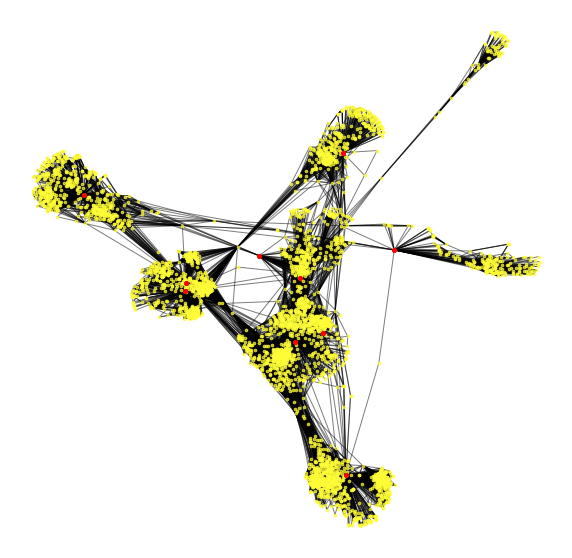

In [23]:
# PRINT
labels = ['' if v is None else v for v in labels]
dic_label = { nodes[labels.index(i)] : str(i) for i in labels }

print("Highlight nodes with the highest betweenness centrality:")
plot_network(G, position, nodes, np.array(high_btw_10)[:,0] , 'r', True, True, dic_label)

From the previous plot, it is evident that nodes (red ones) which links different clusters play a fundamental role. They have an high betw_cent because they are linked to a lot of people of diffrent clusters.Then, everytime that a path has to move from one cluster to another, it has to pass through them.

**Eigenvector Centrality**: is a measure of the influence of a node in a network. It quantifies how well connected a vertex is, especially to vertices that are themselves well connected.

Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors.

Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores. 

Eigenvector centrality is a more sophisticated view of centrality: a person with few connections could have a very high eigenvector centrality if those few connections were to very well-connected others. Eigenvector centrality allows for connections to have a variable value, so that connecting to some vertices has more benefit than connecting to others.

In [24]:
# warning!! the next command is realy slow

#eigenv_centrality = nx.eigenvector_centrality(G) 
#with open('eigen_values.p', 'wb') as fp:
#    pickle.dump(eigenv_centrality, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
with open('eigen_values.p', 'rb') as fp:
    eigenv_centrality = pickle.load(fp)

In [26]:
high_eig_cen = sorted(eigenv_centrality.items(), key=itemgetter(1), reverse=True) #sort
high_eig_cen_10 = high_eig_cen[0:10] # first ten nodes

labels= [None] * num_nodes

print("Nodes with highest EIGENVECTOR CENTRALITY:")
for i in range(10):
    labels[int(np.array(high_eig_cen_10)[i,0])]=str(i+1)
    print(f"Position #{i+1}: node: {high_eig_cen_10[i][0]}, eig_cent: {high_eig_cen_10[i][1]}")

Nodes with highest EIGENVECTOR CENTRALITY:
Position #1: node: 1912, eig_cent: 0.09540696149067629
Position #2: node: 2266, eig_cent: 0.08698327767886553
Position #3: node: 2206, eig_cent: 0.08605239270584343
Position #4: node: 2233, eig_cent: 0.08517340912756598
Position #5: node: 2464, eig_cent: 0.08427877475676092
Position #6: node: 2142, eig_cent: 0.08419311897991796
Position #7: node: 2218, eig_cent: 0.08415573568055032
Position #8: node: 2078, eig_cent: 0.08413617041724979
Position #9: node: 2123, eig_cent: 0.08367141238206226
Position #10: node: 1993, eig_cent: 0.0835324284081597


Highlight nodes with the highest eigenvector centrality:


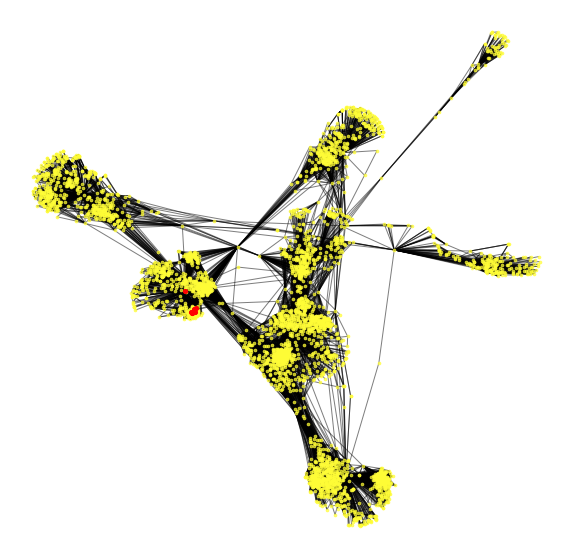

In [27]:
# PRINT

labels = ['' if v is None else v for v in labels]
dic_label = { nodes[labels.index(i)] : str(i) for i in labels }

print("Highlight nodes with the highest eigenvector centrality:")
plot_network(G, position, nodes, np.array(high_eig_cen_10)[:,0] , 'r', True, True, dic_label)


##### Complementary: PageRank

The PageRank algorithm is just a variant of EigenCentrality, but is especially helpful in the case of citations, because, unlike EigenCentrality, it accounts for link direction. Each node in a network is assigned a score based on its number of incoming links (its ‘indegree’). These links are also weighted depending on the relative score of its originating node. The algorithm also takes into account the outgoing connections. The algorithm was originally used by Google in the case of hyperlinks to rank the importances of webpages. For example, the PageRank of a page A is given as:

$$
PR(A) = (1-d) + d \left(\frac{PR(T_1)}{C(T_1)} + ... + \frac{PR(T_n)}{C(T_n)}\right) 
$$

Where $d$ is a damping factor from 0 and 1, $T_1, ..., T_n$ are the incoming citations (the incoming edges), and $C(.)$ is the number of outgoing edges from a node.

Similar to the EigenCentrality case, the result is that nodes with many incoming links are influential, and nodes to which they are connected share some of that influence.

In [28]:
pr = nx.pagerank(G, alpha=0.75)
pr_df = pd.DataFrame.from_dict(pr, orient="index", columns=["pr"])
pr_df.sort_values(by=["pr"], ascending=False).head(10)

,pr
3437,0.007488
107,0.007090
0,0.006383
1684,0.006360
1912,0.003981
348,0.002394
686,0.002171
3980,0.002140
414,0.001876
698,0.001344


## Overall pattern/structure of the network

- density
- average path lenght

**Density**: proportions of connections that exists compared to the set of all edges that could exist

In [29]:
density = nx.density(G)

print(f"The density of the whole netwrork is {density}")

The density of the whole netwrork is 0.010819963503439287


The density is not so important when we look at the entire network. In fact, we can see that the graph is divided in clusters. We should look at the density inside each cluster. We will do it after we have defined these clusters.

It is normal thta, if we consider the whole network, we obtain a low density

**Average path length**: average lengths of shortest paths for all pairs of vertices

In [30]:
#av_path_len = nx.average_shortest_path_length(G)
#with open('av_path_len.p', 'wb') as fp:
#    pickle.dump(av_path_len, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('av_path_len.p', 'rb') as fp:
    av_path_len = pickle.load(fp)

print(f"The average lengths of shortest paths of the whole netwrork is {av_path_len}")

The average lengths of shortest paths of the whole netwrork is 3.6925068496963913


## Shortest Path for each node

In the previuos cells, we found the average path lenght for the whole network. The goal of our analysis is to find central players, so we need to find for each person, the average of all shortest paths to reach other nodes

In [31]:
# function for one specific node
def av_path_len_single_node(G,node):

    # single_source_dijkstra computes shortest paths and lengths in a weighted graph G.
    # Returns a tuple of two dictionaries keyed by node. The first dictionary stores distance from the source. 
    # The second stores the path from the source to that node.
    two_dict = nx.single_source_dijkstra(G,node)
    
    # we are interest only in values of the first dictionary
    values_len = list(two_dict)[0].values()

    #then we want the mean    
    return np.mean(list(values_len))

#av_path_len_node = [av_path_len_single_node(G,x) for x in nodes] # apply the function to all nodes
#with open('av_path_len_node.p', 'wb') as fp:
#    pickle.dump(av_path_len_node, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
with open('av_path_len_node.p', 'rb') as fp:
    av_path_len_node = pickle.load(fp)

In [33]:
# save result in a dictionary. key:node, value: av_path_len_node. Then we sort
dictionary = dict(zip(nodes, av_path_len_node)) # create the dic
av_path_len_node_sorted = sorted(dictionary.items(), key=itemgetter(1)) #sort

av_path_len_node_sorted_10 = av_path_len_node_sorted[:10]

labels= [None] * num_nodes

print("Nodes with shorted path average:")
for i in range(10):
    labels[int(np.array(av_path_len_node_sorted_10)[i,0])]=str(i+1)
    print(f"Position #{i+1}: node {av_path_len_node_sorted_10[i][0]}, shortest path average: {av_path_len_node_sorted_10[i][1]}")


Nodes with shorted path average:
Position #1: node 107, shortest path average: 2.174795741520178
Position #2: node 58, shortest path average: 2.51572171329537
Position #3: node 428, shortest path average: 2.532062391681109
Position #4: node 563, shortest path average: 2.538004456548651
Position #5: node 1684, shortest path average: 2.539985144837831
Position #6: node 171, shortest path average: 2.6984402079722702
Position #7: node 348, shortest path average: 2.702649170586779
Position #8: node 483, shortest path average: 2.703144342659074
Position #9: node 414, shortest path average: 2.705372616984402
Position #10: node 376, shortest path average: 2.7274077742015352


Highlight nodes with the shorted path average::


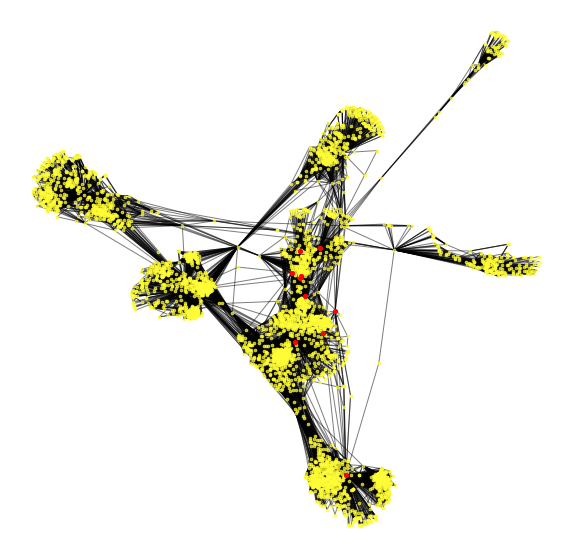

In [34]:
print("Highlight nodes with the shorted path average::")
plot_network( G, position, nodes, np.array(av_path_len_node_sorted_10)[:,0], 'r', True, True, dic_label)

## Most important nodes:
At this point we have the most relevant nodes in terms of the following characteristics:
- Node degree
- Betweenness
- Eigenvector centrality
- Shortest path

**Common Plot**
Now, we plot all these different types of significant nodes

- Node degree : red
- Betweenness : light blue
- Eigenvector centrality : pink
- Shortest path : green

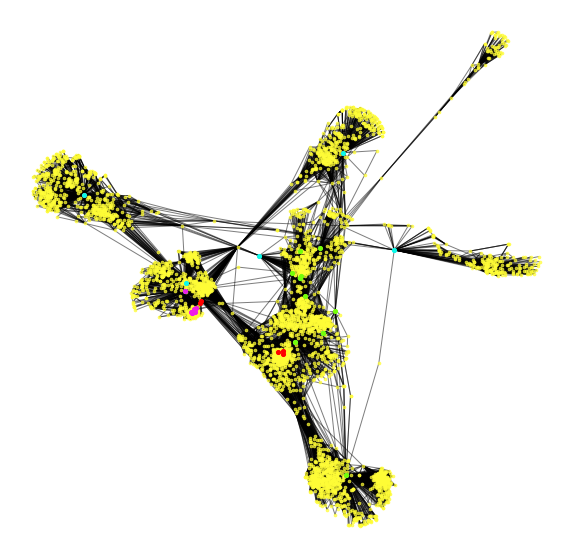

In [35]:
plot_network(G, position, nodes, centrality_10, 'r', True, False, [])
plot_network(G, position, nodes, np.array(high_btw_10)[:,0] , '#0bf9ea', False, False, [])
plot_network(G, position, nodes, np.array(high_eig_cen_10)[:,0]  , '#ef1de7' , False, False, [])
plot_network(G, position, nodes, np.array(av_path_len_node_sorted_10)[:,0]  , '#75fe08' , False, True, [])

In order to find most relevant nodes we create a dataframe where we same, for each node, its position in terms of the relevant features.

As first thing, for each feature we create one dataframe, thwn we merge them togheter. For exaample, in the first one, nodes are nodes number and pos_cent represents the importance of the node in terms of centrality

In [36]:
#centrality
centrality_df = pd.DataFrame( data = [range(num_nodes),map(int, centrality)]).T.rename(columns={0: "pos_bet", 1: "nodes"})
centrality_df = centrality_df.sort_values(by="nodes").set_index("nodes")
centrality_df.head(10)

,pos_bet
nodes,
0,4
1,2561
2,3157
3,2528
4,3104
5,2858
6,3496
7,2286
8,3283


node 0 is number 5 (start from 0) in terms of importance. so it is quite important

In [37]:
# betweenness
high_betw = map(int, np.array(high_btw)[:,0])
high_betw_df = pd.DataFrame( data = [range(num_nodes),high_betw]).T.rename(columns={0: "pos_betw", 1: "nodes"})
high_betw_df = high_betw_df.sort_values(by="nodes").set_index("nodes")

# eigenvectore centrality
high_eig = map(int, np.array(high_eig_cen)[:,0])
high_eig_df = pd.DataFrame( data = [range(num_nodes),high_eig]).T.rename(columns={0: "pos_eig", 1: "nodes"})
high_eig_df = high_eig_df.sort_values(by="nodes").set_index("nodes")

# shortest path
av_path = map(int, np.array(av_path_len_node_sorted)[:,0])
av_path_df = pd.DataFrame( data = [range(num_nodes),av_path]).T.rename(columns={0: "pos_short_path", 1: "nodes"})
av_path_df = av_path_df.sort_values(by="nodes").set_index("nodes")

In [38]:
node_rank = pd.DataFrame(data = [range(num_nodes)] ).T
node_rank = pd.merge(node_rank, centrality_df,  left_index = True, right_index = True).set_index(0)
node_rank = pd.merge(node_rank, high_betw_df,  left_index = True, right_index = True)
node_rank = pd.merge(node_rank, high_eig_df,  left_index = True, right_index = True)
node_rank = pd.merge(node_rank, av_path_df,  left_index = True, right_index = True)
node_rank = node_rank.sort_index()
node_rank

,pos_bet,pos_betw,pos_eig,pos_short_path
0,,,,
0,4,5,1004,26
1,2561,2051,2065,2683
2,3157,3453,2253,2760
3,2528,2350,2054,2684
4,3104,3260,2250,2761
...,...,...,...,...
4034,3885,4036,3813,3888
4035,3985,4037,3832,3896
4036,3884,4038,3821,3889


At this point, we have a dataframe where, for each node, we have its rank for different features. Supposing that, each feature is equally important (the company can change the weight of each characteristics accoridng to its needs), now we can do the mean and find the global rank for each node.

In [39]:
# idea: in total_rank_point there is the rank mean of each node, in order to have a ranking in 0,1,2... the easiest thing is
#to order dataframe for this column, then add another column with integer 0,1,2... and then drop the total_rank_point column
node_rank["total_rank_point"] = (node_rank.pos_bet + node_rank.pos_betw + node_rank.pos_eig +\
                                 node_rank.pos_short_path)/4
node_rank = node_rank.sort_values("total_rank_point")
node_rank["total_rank"] = range(num_nodes)

In [40]:
node_rank.head(10)

,pos_bet,pos_betw,pos_eig,pos_short_path,total_rank_point,total_rank
0,,,,,,
1912,2,3,0,27,8.00,0
1577,141,13,245,21,105.00,1
1718,197,15,337,22,142.75,2
1465,430,20,272,25,186.75,3
107,0,0,756,0,189.00,4
1663,9,88,758,43,224.50,5
1352,11,87,759,44,225.25,6
1126,47,102,760,51,240.00,7
1621,75,108,761,52,249.00,8


In [41]:
print("Most important nodes are (influencer): \n")

for i in range(15):
    print(f"Position #{i+1}: node {node_rank.index[i]}")

Most important nodes are (influencer): 

Position #1: node 1912
Position #2: node 1577
Position #3: node 1718
Position #4: node 1465
Position #5: node 107
Position #6: node 1663
Position #7: node 1352
Position #8: node 1126
Position #9: node 1621
Position #10: node 1835
Position #11: node 1376
Position #12: node 0
Position #13: node 925
Position #14: node 1420
Position #15: node 1361


In [42]:
print("Irrelevant nodes are nodes are: \n")

for i in range(15):
    pos = len(nodes) - 15 + i
    print(f"Position #{pos+1}: node {node_rank.index[pos]}")

Irrelevant nodes are nodes are: 

Position #4025: node 3984
Position #4026: node 4008
Position #4027: node 4010
Position #4028: node 4015
Position #4029: node 4022
Position #4030: node 4024
Position #4031: node 4035
Position #4032: node 744
Position #4033: node 699
Position #4034: node 750
Position #4035: node 749
Position #4036: node 775
Position #4037: node 841
Position #4038: node 692
Position #4039: node 801


In [43]:
node_rank = node_rank.drop(columns="total_rank_point").sort_index()
node_rank.head(10)

,pos_bet,pos_betw,pos_eig,pos_short_path,total_rank
0,,,,,
0,4,5,1004,26,11
1,2561,2051,2065,2683,2444
2,3157,3453,2253,2760,3199
3,2528,2350,2054,2684,2520
4,3104,3260,2250,2761,3118
5,2858,2207,1990,2730,2575
6,3496,3617,2296,2822,3385
7,2286,292,1053,2183,1312
8,3283,3153,2279,2788,3161


## Cluster Analysis

First of all, we indetify principal clusters

In [44]:
# this function does not work for versions of python after 3.6

#Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices
clusters = community_louvain.best_partition(G) 

In [45]:
num_cluster = max(clusters.values())
print(f"The community can be divided in {num_cluster} communities.")

The community can be divided in 15 communities.


This partition does not create clusters of the same number of nodes:

In [46]:
conts_nodes = [ list(clusters.values()).count(x) for x in range(num_cluster) ]
nodes_cluster = [0] * num_cluster # nodes of that cluster

for i in range(num_cluster):
    nodes_cluster[i] = [nodes for nodes in clusters.keys() if clusters[nodes] == i]
    print(f"Cluster #{i}: nodes #{conts_nodes[i]}")

Cluster #0: nodes #354
Cluster #1: nodes #432
Cluster #2: nodes #432
Cluster #3: nodes #423
Cluster #4: nodes #535
Cluster #5: nodes #323
Cluster #6: nodes #127
Cluster #7: nodes #548
Cluster #8: nodes #73
Cluster #9: nodes #237
Cluster #10: nodes #25
Cluster #11: nodes #60
Cluster #12: nodes #206
Cluster #13: nodes #226
Cluster #14: nodes #19


In [47]:
# colors clusters
colors = []

for i in range(num_cluster):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

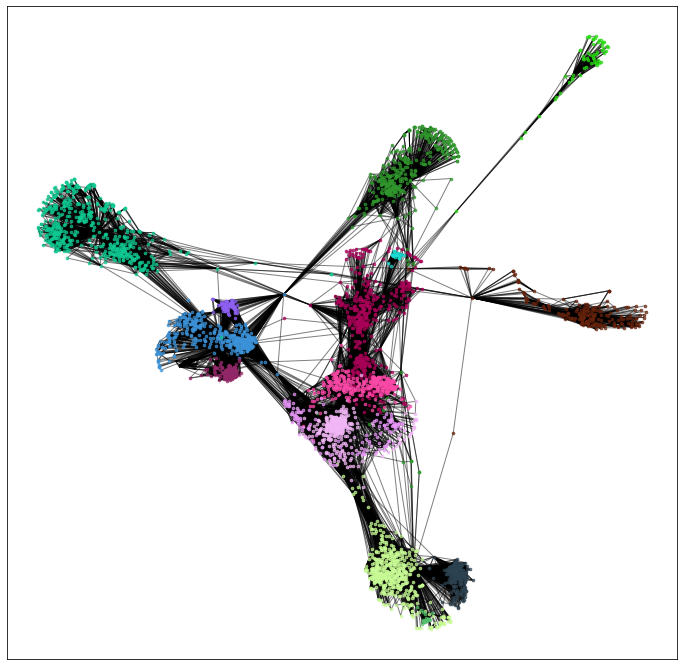

In [48]:
#plot
plt.figure(figsize = (12,12))

nx.draw_networkx_edges(G, position, alpha = 0.5)

for i in range(num_cluster):
    nx.draw_networkx_nodes(G, position,  nodes_cluster[i] , node_size = 7, node_color = colors[i] , alpha = 0.7)

plt.show()

We want to find important nodes for each cluster. Not all clusters have the same number of nodes, so we work in 10% (5% is too low for some clusters). we proceed as above:

In [49]:
print("Most important nodes for each cluster considering \ncentrality, betwenness, eigenvector \
centrality and shortest path:")
for i in range(num_cluster):
    nodes = nodes_cluster[i] # nodes cluster
    sub_G = G.subgraph(nodes)
    num_nodes_c = len(nodes)
    
    
    # centrality
    centr = calculate_centrality(sub_G, nodes)
    degree_most_connected = G.degree(centr)
    
    node_rank = pd.DataFrame( data = [range(num_nodes_c),map(int, centr)]).T.rename(columns={0: "pos_bet", 1: "nodes"})
    node_rank = node_rank.sort_values(by="nodes").set_index("nodes")
    
    #node_rank = pd.merge(node_rank, centrality_df,  left_index = True, right_index = True)
    
    # betwenness
    betweenness = nx.betweenness_centrality(sub_G)
    high_btw = sorted(betweenness.items(), key=itemgetter(1), reverse=True) #sort
    
    high_betw = map(int, np.array(high_btw)[:,0])
    high_betw_df = pd.DataFrame( data = [range(num_nodes_c),high_betw]).T.rename(columns={0: "pos_betw", 1: "nodes"})
    high_betw_df = high_betw_df.sort_values(by="nodes").set_index("nodes")
    
    node_rank = pd.merge(node_rank, high_betw_df,  left_index = True, right_index = True)
    
  
    # eigenvector centrality
    eigenv_centrality = nx.eigenvector_centrality(sub_G)
    high_eig_cen = sorted(eigenv_centrality.items(), key=itemgetter(1), reverse=True) #sort
    
    high_eig = map(int, np.array(high_eig_cen)[:,0])
    high_eig_df = pd.DataFrame( data = [range(num_nodes_c),high_eig]).T.rename(columns={0: "pos_eig", 1: "nodes"})
    high_eig_df = high_eig_df.sort_values(by="nodes").set_index("nodes")

    node_rank = pd.merge(node_rank, high_eig_df,  left_index = True, right_index = True)

    # shortest path
    av_path_len_node = [av_path_len_single_node(sub_G,x) for x in nodes]
    dictionary = dict(zip(nodes, av_path_len_node)) # create the dic
    av_path_len_node_sorted = sorted(dictionary.items(), key=itemgetter(1)) #sort

    av_path = map(int, np.array(av_path_len_node_sorted)[:,0])
    av_path_df = pd.DataFrame( data = [range(num_nodes_c),av_path]).T.rename(columns={0: "pos_short_path", 1: "nodes"})
    av_path_df = av_path_df.sort_values(by="nodes").set_index("nodes")

    node_rank = pd.merge(node_rank, av_path_df,  left_index = True, right_index = True)
    
    # dataframe for that subgraph
    ten_per_nodes = int(num_nodes_c/10)
    node_rank["total_rank_point"] = (node_rank.pos_bet + node_rank.pos_betw + node_rank.pos_eig + \
                                     node_rank.pos_short_path)/4
    node_rank = node_rank.sort_values("total_rank_point")
    node_rank["total_rank"] = range(num_nodes_c)
    node_rank = node_rank.drop(columns="total_rank_point").sort_index()

    central_players = list(node_rank.index)[:ten_per_nodes]

    print(f"Cluster {i}: \n {central_players}\n")
    

Most important nodes for each cluster considering 
centrality, betwenness, eigenvector centrality and shortest path:
Cluster 0: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]

Cluster 1: 
 [34, 173, 198, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387]

Cluster 2: 
 [107, 897, 899, 904, 906, 907, 911, 916, 918, 920, 921, 922, 925, 926, 927, 932, 934, 946, 947, 952, 953, 959, 960, 961, 966, 967, 972, 973, 978, 980, 982, 983, 991, 993, 995, 996, 997, 998, 999, 1002, 1003, 1004, 1006]

Cluster 3: 
 [136, 1465, 1577, 1718, 1912, 1913, 1915, 1916, 1920, 1922, 1923, 1926, 1930, 1932, 1933, 1934, 1936, 1937, 1939, 1940, 1941, 1944, 1945, 1947, 1948, 1949, 1952, 1954, 1955, 1956, 1959, 1960, 1961, 1964, 1965, 1969, 1970, 1974, 1975, 1977, 1978, 1981]

Cluster 4

Maybe our company is not interest in the shortes path, but prefer to work only on the other 3 features. In this case:

In [50]:
print("Most important nodes for each cluster considering \ncentrality, betwenness and eigenvectore centrality: \n")

central_players = [None] * num_cluster

for i in range(num_cluster):
    nodes = nodes_cluster[i] # nodes cluster
    sub_G = G.subgraph(nodes)
    num_nodes_c = len(nodes)
    
    
    # centrality
    centr = calculate_centrality(sub_G, nodes)
    degree_most_connected = G.degree(centr)
    
    node_rank = pd.DataFrame( data = [range(num_nodes_c),map(int, centr)]).T.rename(columns={0: "pos_bet", 1: "nodes"})
    node_rank = node_rank.sort_values(by="nodes").set_index("nodes")
    
    #node_rank = pd.merge(node_rank, centrality_df,  left_index = True, right_index = True)
    
    # betwenness
    betweenness = nx.betweenness_centrality(sub_G)
    high_btw = sorted(betweenness.items(), key=itemgetter(1), reverse=True) #sort
    
    high_betw = map(int, np.array(high_btw)[:,0])
    high_betw_df = pd.DataFrame( data = [range(num_nodes_c),high_betw]).T.rename(columns={0: "pos_betw", 1: "nodes"})
    high_betw_df = high_betw_df.sort_values(by="nodes").set_index("nodes")
    
    node_rank = pd.merge(node_rank, high_betw_df,  left_index = True, right_index = True)
    
  
    # eigenvectore centrality
    eigenv_centrality = nx.eigenvector_centrality(sub_G)
    high_eig_cen = sorted(eigenv_centrality.items(), key=itemgetter(1), reverse=True) #sort
    
    high_eig = map(int, np.array(high_eig_cen)[:,0])
    high_eig_df = pd.DataFrame( data = [range(num_nodes_c),high_eig]).T.rename(columns={0: "pos_eig", 1: "nodes"})
    high_eig_df = high_eig_df.sort_values(by="nodes").set_index("nodes")

    node_rank = pd.merge(node_rank, high_eig_df,  left_index = True, right_index = True)
    
    # dataframe for that subgraph
    ten_per_nodes = int(num_nodes_c/10)
    node_rank["total_rank_point"] = (node_rank.pos_bet + node_rank.pos_betw + node_rank.pos_eig)/3
    node_rank = node_rank.sort_values("total_rank_point")
    node_rank["total_rank"] = range(num_nodes_c)
    node_rank = node_rank.drop(columns="total_rank_point").sort_index()

    central_players[i] = list(node_rank.index)[:ten_per_nodes]

    print(f"Cluster {i}: \n {central_players[i]}\n")
    

Most important nodes for each cluster considering 
centrality, betwenness and eigenvectore centrality: 

Cluster 0: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]

Cluster 1: 
 [34, 173, 198, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387]

Cluster 2: 
 [107, 897, 899, 904, 906, 907, 911, 916, 918, 920, 921, 922, 925, 926, 927, 932, 934, 946, 947, 952, 953, 959, 960, 961, 966, 967, 972, 973, 978, 980, 982, 983, 991, 993, 995, 996, 997, 998, 999, 1002, 1003, 1004, 1006]

Cluster 3: 
 [136, 1465, 1577, 1718, 1912, 1913, 1915, 1916, 1920, 1922, 1923, 1926, 1930, 1932, 1933, 1934, 1936, 1937, 1939, 1940, 1941, 1944, 1945, 1947, 1948, 1949, 1952, 1954, 1955, 1956, 1959, 1960, 1961, 1964, 1965, 1969, 1970, 1974, 1975, 1977, 1978, 1981]

Cluster 4: 
 [990, 11

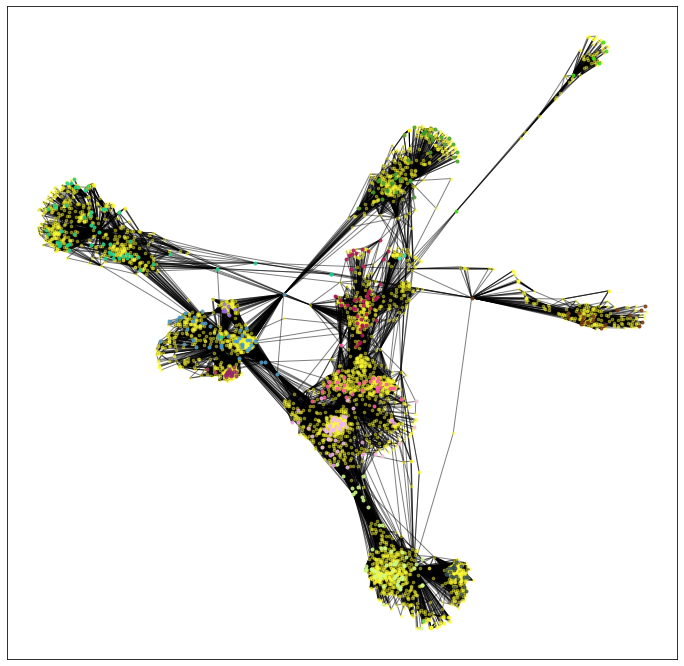

In [55]:
# plot most important nodes:
plt.figure(figsize = (12,12))

nx.draw_networkx_edges(G, position, alpha = 0.5)
nx.draw_networkx_nodes(G, position, G.nodes, node_size = 7, node_color = "#fffd37" , alpha = 0.4)


for i in range(num_cluster):
    central_players[i] = [str(x) for x in central_players[i]]
    nx.draw_networkx_nodes(G, position,  central_players[i] , node_size = 9, node_color = colors[i] , alpha = 0.7)
plt.show()